# How do we eat???????

**Milestone 2 of final project (Applied Data Analysis)**

**Team: Salmon Tortilla al Pesto**

This jupyter notebook correspond to one part (out of two) of the total report for this milestone. In this notebook we work on the [recpies dataset](http://pic2recipe.csail.mit.edu). Here we will import the dataset, analyize it, search for missing data, clean it, filter it, and start the analysis to ensure that everything is ok for the final milestone. Before starting with all the mentioned tasks, we will present the idea and objectives of this part of the project.

Nowadays, huge advances in medicine and nutrition have led us to understand that the way we eat plays the most important role in our health. Following a diet rich in omega 6, for example, will lead us into different diseases, like cancer. Avoiding bad diets is “easily” achieved by eating a great variety of different food, at the same time as, minimizing the amount of unhealthy meals. However, things can get harder when we have certain restrictions or obligations in our diet, for instance, we have to counter a lack of iron or if we are vegan.

In this part of the project, we will use the `Recipe1M+` dataset to find the correlation between ingredients and see which ingredients are more likely to appear together in a recipe. This way, we will investigate how some restriction or obligations in our diets can affect undesired raises in specific aliments. 

This are some of the questions we want to answer in this project:

- What is the presence correlation between ingredients in recipes?
- Are there increases/decreases in the consumption of some ingredients when fighting against a specific disease via nutrition?
- Are there increases/decreases in the consumption of some ingredients when having restrictions in our diet?
- Which recipes are recommended to fight against a specific disease while not resulting in an undesirable increase of some other ingredients?

In this first approach, we will base our project in 5 specific nutrition situations:

- Lactose intolerance
- Gluten intolerance
- Vegetarian diet
- Countering lack of iron
- Countering lack of omega 3



## Table of contents

**1. Analysis and cleaning of the datasets:** In this part we import the data, look for missing or/and NaN values, clean the data, format it if needed and filter it.

**2. General analysis of the data:** Before going into the analysis we intent to do, we first do a more general analysis of the ingredients in recepies to obtain important information we will need for extracting the proper conclusions.

**3. Correlation between ingredients:** In this part we start with the analysis of the correlation of ingredients to see what are we facing and if whether or not what we inteded to do is feasable.

**4. Analysis of selected diets:** In this part we will really start with the project in order to see that everything is ok for the final report.

In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import time
import operator

In [2]:
# For beauty printing
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [3]:
# Main printing function
def printMain(to_print):
    print(color.BLUE + color.BOLD + to_print + color.END)

## 1) Analysis and cleaning of the datasets

In this first section we get the datasets into pandas and analyise the structure and the content of them. The we find and handle NaN and missing values, cleand and format the data, and filter it to remove unnecesary features or items. Finally we adapt the data for the following analysis.

We have two datasets: `layer1.json` that has information about list of recepies, and `det_ingrs.json` with the ingredients of the recepies from the previous dataset in a cleaner way.

### Importing the data
First of all, lets import both datasets and analyse them.

In [4]:
# Importing layer1.json
initial_time = time.time()
df_recepies = pd.read_json('data/layer1.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("layer1.json dataset:")
df_recepies.head()

(Time: 45.91 seconds)
layer1.json dataset:


,ingredients,url,partition,title,id,instructions
0,"[{'text': '6 ounces penne'}, {'text': '2 cups ...",http://www.epicurious.com/recipes/food/views/-...,train,Worlds Best Mac and Cheese,000018c8a5,[{'text': 'Preheat the oven to 350 F. Butter o...
1,"[{'text': '1 c. elbow macaroni'}, {'text': '1 ...",http://cookeatshare.com/recipes/dilly-macaroni...,train,Dilly Macaroni Salad Recipe,000033e39b,[{'text': 'Cook macaroni according to package ...
2,"[{'text': '8 tomatoes, quartered'}, {'text': '...",http://www.foodnetwork.com/recipes/gazpacho1.html,train,Gazpacho,000035f7ed,[{'text': 'Add the tomatoes to a food processo...
3,"[{'text': '2 12 cups milk'}, {'text': '1 12 cu...",http://www.food.com/recipe/crunchy-onion-potat...,test,Crunchy Onion Potato Bake,00003a70b1,[{'text': 'Preheat oven to 350 degrees Fahrenh...
4,[{'text': '1 (3 ounce) package watermelon gela...,http://www.food.com/recipe/cool-n-easy-creamy-...,train,Cool 'n Easy Creamy Watermelon Pie,00004320bb,"[{'text': 'Dissolve Jello in boiling water.'},..."


In [5]:
# Importing det_ingrs.json
initial_time = time.time()
df_ingredients = pd.read_json('data/det_ingrs.json')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset:")
df_ingredients.head()

(Time: 17.38 seconds)
det_ingrs.json dataset:


,valid,id,ingredients
0,"[True, True, True, True, True, True, True, Tru...",000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,"[True, True, True, True, True, True, True, Tru...",000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,"[True, True, True, True, True, True, True, Tru...",000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,"[True, True, True, True, True, True, True]",00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,"[True, True, True, True, True]",00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


We can see that the first dataset has no information interesting for our analysis so far. The title, url and insturctions are not useful for us, and the ingridients will be taken from the `df_ingredients` as they are more clean, and so, easier to use. We delete the first dataFrame.

In [6]:
# Deleting the first dataset
del df_recepies 

### Removing unnecessary data

In the `df_ingredients` we have 3 columns. The `ingredients` column is the most important one. `id` columns will be kept in the dataset, just in case we need to relate the two datasets in the future. The `valid` column will be deleted as it is not needed. Let's delete that feature.

In [7]:
df_ingredients = df_ingredients.drop(columns=['valid'])
df_ingredients.head()

,id,ingredients
0,000018c8a5,"[{'text': 'penne'}, {'text': 'cheese sauce'}, ..."
1,000033e39b,"[{'text': 'elbow macaroni'}, {'text': 'America..."
2,000035f7ed,"[{'text': 'tomatoes'}, {'text': 'kosher salt'}..."
3,00003a70b1,"[{'text': 'milk'}, {'text': 'water'}, {'text':..."
4,00004320bb,"[{'text': 'watermelon gelatin'}, {'text': 'boi..."


### Reformating data

We can also see that the `ingredients` column is not good formated. It will be more useful to have only a list of the ingredient of each recepie. Let's format it.

In [8]:
def convert_to_array(ingredients_json):
    to_return = []
    for ingredient in ingredients_json:
        to_return.append(ingredient['text'])
    return to_return

initial_time = time.time()
df_ingredients['ingredients'] = df_ingredients['ingredients'].apply(convert_to_array)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("det_ingrs.json dataset after cleaning:")
df_ingredients.head()

(Time: 4.21 seconds)
det_ingrs.json dataset after cleaning:


,id,ingredients
0,000018c8a5,"[penne, cheese sauce, cheddar cheese, gruyere ..."
1,000033e39b,"[elbow macaroni, American cheese, celery, gree..."
2,000035f7ed,"[tomatoes, kosher salt, red onion, green bell ..."
3,00003a70b1,"[milk, water, butter, mashed potatoes, whole k..."
4,00004320bb,"[watermelon gelatin, boiling water, Cool Whip,..."


### Dealing with missing data

Before moving on, let's look if the dataframe has NaN data or empty list of ingredients:

In [9]:
# Looking for NaN values
printMain("Are there any null values?")
df_ingredients.isnull().values.any()

Are there any null values?


False

In [10]:
# Looking for empty lists
df_empty_rows = df_ingredients[df_ingredients['ingredients'].map(lambda d: len(d)) == 0]
printMain("What is the number of empty ingredient lists?")
len(df_empty_rows)

What is the number of empty ingredient lists?


0

We can see that there are no missing or empty values. Nothing to clean or fill.

### Filtering ingredients

Now we have the dataframe with the list of ingredients we wanted. However we realized that some ingredients were not properly cleaned as expected. Let's see what it is exactly the problem.

For this, let's make a list of all the ingredients that appear at least once in the dataframe.

In [11]:
# Ingridients unique 
initial_time = time.time()
list_ingredients = []
 
for row in df_ingredients.itertuples():
    list_ingredients.extend(row[2])

list_ingredients = list(set(list_ingredients))    
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Amount of different ingredients: " + str(len(list_ingredients)))

(Time: 2.86 seconds)
Amount of different ingredients: 170532


In [12]:
# Let's print a few of the ingredients
list_ingredients[-10:]

['1 sm. can green minced chilies',
 'semisweet chocolate bars',
 '1 [Apple]',
 'veal sausage',
 '6 frico (see recipe below)',
 '1 package (1 Oz. Size) McCormick Grill Mates Baja Citrus Marinade Mix',
 '1 ounce Cocchi Americano (fortified, slightly bitter aperitif wine)',
 '3/4 cup (175 ml) plus 1 tbsp (15 ml) unsweetened orange juice CONCENTRATE(Minute Maid reduced acid)',
 '1 box frzn minced spinach - (10 ounce) thawed',
 '1 pk chocolate kisses']

We can see in the above cell that some ingredients are still not properly cleaned. For example, the fifth ingredient printed `3 Packages frzn broccoli`, should be seen as `broccoli` as we do not care about the ammount a we need the ingredients that are the same to be the same string. This is important for the future analysis. 

In order to avoid having this ingredients we decided to reduce the number of recepies we have, deleting all the recepies that have this "not-cleaned" ingredients. To identify this "not-cleaned" ingredients, we suppose that are does that appear in less than 50 recepies (is hard that an ingredient that is not cleaned appears more). 

Let's first see how many recepies we have in total before doing the cleaning.

In [13]:
printMain("Number of recepies: " + str(len(df_ingredients)))

Number of recepies: 1029720


In [14]:
# First, let's put the ingredients into a dictionary
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 4.34 seconds)


In [35]:
# Creating a list of ingredients that appear more than 50 times
initial_time = time.time()
max_ingredients = []
for k, v in dic_ingredients.items():
    if v > 50:
        max_ingredients.append(k)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of ingredients that appear more than 50 times: " + str(len(max_ingredients)))

(Time: 0.04 seconds)
Number of ingredients that appear more than 50 times: 5808


In [36]:
# Deleting the recepies with "not-cleaned" ingredients
def deleting_rcepies_with_strange_ingredients(x):
    for i in x:
        if i not in max_ingredients:
            return False
    return True

initial_time = time.time()
df_ingredients = df_ingredients[df_ingredients["ingredients"].apply(deleting_rcepies_with_strange_ingredients)]
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Number of recepies: " + str(len(df_ingredients)))

(Time: 79.61 seconds)
Number of recepies: 781268


We can see we go from little more than 1 million of recepies, to nearly 800.000 recepies. So, eventhough we loose more than 200.000 recepies, it is not critical for the purpose of the project. We still have enough data for the analysis we ment to carry on. 

### Selecting ingredients for future analysis

Before moving on to the next part, we want to mention that we are going to base our analysis in only a small set of the 5808 ingredients, in the 300 most important. Doing the analysis in all of the ingredients would be time consuming and also irrelevant.

In [44]:
# First, we recalculate the dictionary of ingredients
initial_time = time.time()
dic_ingredients = {}
 
for row in df_ingredients.itertuples():
    for ing in row[2]:
        if ing in dic_ingredients:
            dic_ingredients[ing] += 1
        else:
            dic_ingredients[ing] = 1

print("(Time:", round(time.time() - initial_time, 2), "seconds)")

(Time: 3.48 seconds)


In [45]:
# Selecting the ingredients
initial_time = time.time()
sorted_ingredients = sorted(dic_ingredients.items(), key=operator.itemgetter(1), reverse=True)
sorted_ingredients_300 = sorted_ingredients[:300]
ingredients = []
for i in sorted_ingredients_300:
    ingredients.append(i[0])
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("Top 5 ingredients: " + str(ingredients[:10]))

(Time: 0.03 seconds)
Top 5 ingredients: ['salt', 'butter', 'sugar', 'olive oil', 'eggs', 'water', 'garlic cloves', 'milk', 'flour', 'all - purpose flour']


### Adding new necessary data

For the 300 ingredients we want to analyze, we want to now if they are recommended or avoided by the 5 diets we are studing. This work cannot be done automatically, therefore, we proceed to export the 300 ingredients to an Excel file, add the necessary information to it, and reimport it to the notebook as a dataFrame for future analysis.

In [47]:
# Exporting the data
pd.DataFrame(sorted_ingredients_300).to_excel('data/ingredients_without_analysis.xlsx', header=False, index=False)

In [48]:
# Importing the data
initial_time = time.time()
df_300_ingredients = pd.read_excel('data/ingredients.xlsx', index_col=0)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame of top 300 ingredients: ")
df_300_ingredients.head(10)

(Time: 0.07 seconds)
DataFrame of top 300 ingredients: 


,Amount,Lactose,Gluten,Vegetarian,Iron,Omega 3,Strange
Ingredient,,,,,,,
salt,292619,1,1,1,0,0,0
butter,192640,0,0,1,0,0,0
sugar,173642,1,1,1,0,0,0
olive oil,131961,1,1,1,0,0,0
eggs,122748,1,1,1,0,0,0
water,117601,1,1,1,1,1,0
garlic cloves,102192,1,1,1,0,0,0
milk,85206,0,1,1,0,0,0
flour,84711,1,0,1,0,0,1


This new dataframe contains 6 new columns for each one of the 300 ingredients:

- Lactose: Whether or not a lactose intolerance person can eat this ingredient (1: Yes, 0: No)
- Gluten: Whether or not a gluten intolerance person can eat this ingredient (1: Yes, 0: No)
- Vegetarian: Whether or not a vegetarian person can eat this ingredients (1: Yes, 0: No)
- Iron: Weather or not this ingrededient is recomended for countering a lack of iron (1: Yes, 0: No)
- Omega 3: Weather or not this ingrededient is recomended for countering a lack of omega 3 (1: Yes, 0: No)
- Strange: If this ingredient has something strange to be analysed is marked with a 1 (see next cells)

**TODO: Analysis of stranges**

**TODO: Explain the selection of ingredients for Omega 3 and Iron**

----

## 2) General analysis of the data

In this part of the report we analyse the characteristics of the recepies in terms of the ingredient in a more general way. We try to ansewer this questions:

**Todo: Make list of questions**

If any new thing that needs to be cleaned or filtered appears in the data, it is also done in this part.

### Distribution of ingredients

Number of total ingredients: 5808 


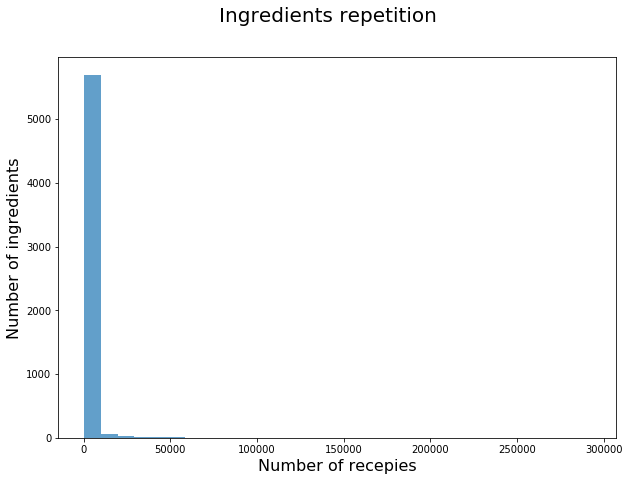

In [49]:
initial_time = time.time()
repetitionArray = []
for i in sorted_ingredients:
    repetitionArray.append(i[1])
    
print(color.GREEN + "Number of total ingredients:", len(repetitionArray), color.END)
fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recepies', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray,bins=30, alpha=0.7)
plt.show(fig)

In the above plot we can not really see how the distribution of ingredients appearances is, but we can know that the big mayority of ingredients (> 160000, nearly 100%) appear in a low ammount of recepies. 

Let's do the same analysis but with ingredients in more than 1500 appearances.

Number of total ingredients: 654 


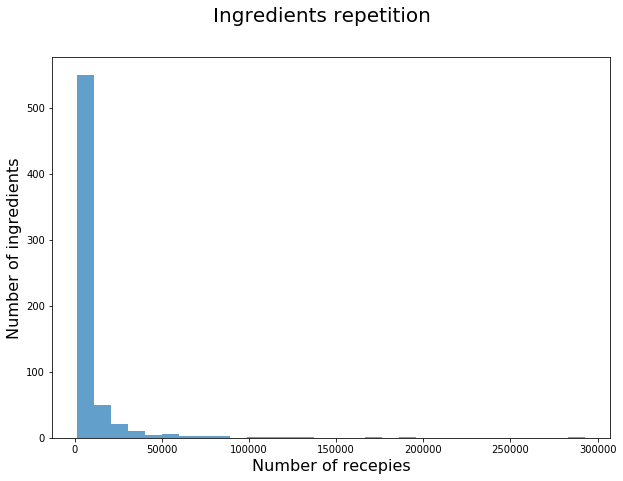

In [50]:
initial_time = time.time()
repetitionArray2 = []
for i in sorted_ingredients:
    if i[1] > 1500:
        repetitionArray2.append(i[1])
    
print(color.GREEN + "Number of total ingredients:", len(repetitionArray2), color.END)
fig, ax = plt.subplots(figsize=(10, 7))
fig.suptitle('Ingredients repetition', fontsize=20)
plt.xlabel('Number of recepies', fontsize=16)
plt.ylabel('Number of ingredients', fontsize=16)
ax.hist(repetitionArray2, bins=30, alpha=0.7)
plt.show(fig)

Eventhough we have zoomed to avoid the ingredients repeated a few number of times, we still see that there are much more ingredients in the lower repetition part of the histogram. This shows us that we base our diety in a small ammount of ingredients, depending a lot on it. Let's see for example for the top 10 ingredients, the percentage of recepies they appear on:

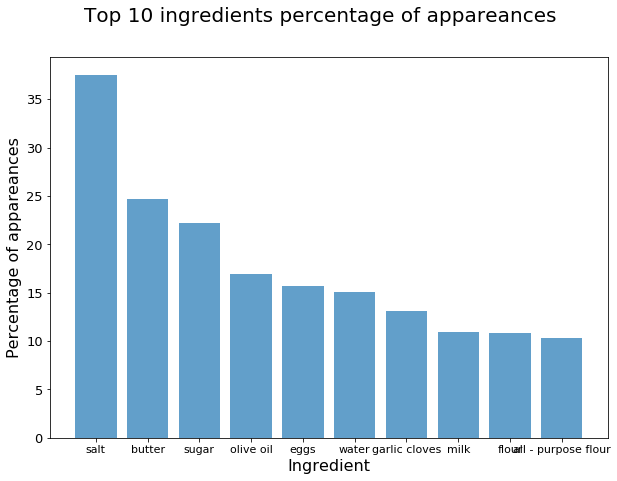

In [51]:
top10_ingredients = ingredients[:10]
top10_percentages = []

for i in repetitionArray2[:10]:
    top10_percentages.append(100*(i/len(df_ingredients)))

fig, ax = plt.subplots(figsize=(10, 7))
plt.bar(np.arange(len(top10_percentages)), top10_percentages,
       align='center',
       alpha=0.7,
       ecolor='black',
       capsize=10, 
       tick_label=top10_ingredients) 
fig.suptitle('Top 10 ingredients percentage of appareances', fontsize=20)
plt.ylabel('Percentage of appareances', fontsize=16)
plt.xlabel('Ingredient', fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=13)
plt.show()

We can see that there are some ingredients really dominant like for example `salt` which appears in nearly 50% of the recepies. This will probably be bad for the main analysis as this ingredients will be present in many recpies no matter the ingredient we choose. It is also interesting to see how the three main ingredients (`salt`, `butter` and `sugar`) are ingredients heavely related to diseases (**todo: reference**). Also interesting to see how 2 out of the 10 top ingredients are not eatable by vegan people, and that the 9th ingredient is not eatable by gluten intolerance people. 

### Number of ingredients per recepie analysis

In [52]:
initial_time = time.time()
df_ingredients['length'] = df_ingredients['ingredients'].apply(lambda x: len(x))
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
printMain("DataFrame with new column: ")
df_ingredients.head()

(Time: 0.36 seconds)
DataFrame with new column: 


,id,ingredients,length
1,000033e39b,"[elbow macaroni, American cheese, celery, gree...",9
2,000035f7ed,"[tomatoes, kosher salt, red onion, green bell ...",9
3,00003a70b1,"[milk, water, butter, mashed potatoes, whole k...",7
5,0000631d90,"[shredded coconut, lean ground beef, fresh gar...",10
6,000075604a,"[chicken thighs, tea, white pepper]",3


(Time: 0.08 seconds)


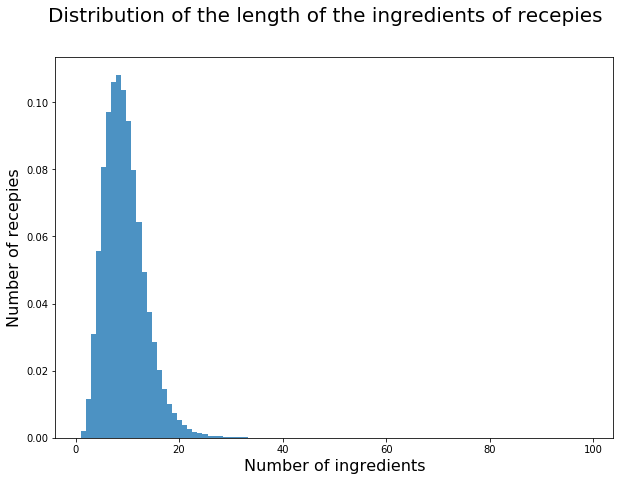

In [25]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(10, 7))
_data = df_ingredients["length"]
fig.suptitle('Distribution of the length of the ingredients of recepies', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recepies', fontsize=16)
plt.hist(_data, density=True, bins=100, alpha=0.8)
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

It can not be seen clearly in the avobe plot, but there are some outliers with a huge ammount of ingredients. Let's print it in a logarithmic scale to see this clearly:

(Time: 0.12 seconds)


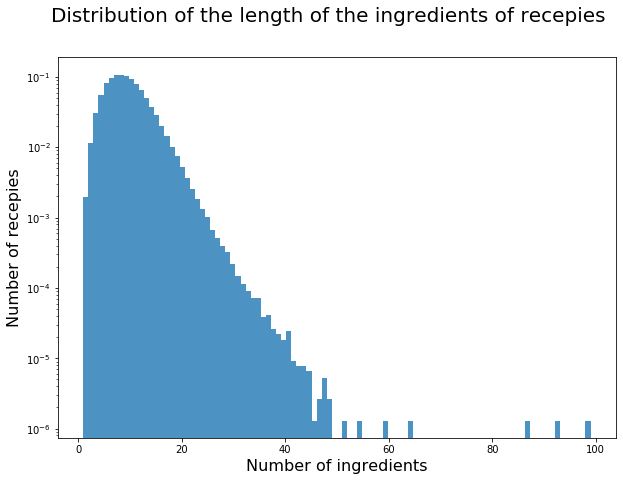

In [24]:
initial_time = time.time()
fig, ax = plt.subplots(figsize=(10, 7))
_data = df_ingredients["length"]
fig.suptitle('Distribution of the length of the ingredients of recepies', fontsize=20)
plt.xlabel('Number of ingredients', fontsize=16)
plt.ylabel('Number of recepies', fontsize=16)
plt.hist(_data, density=True, bins=100, alpha=0.8)
ax.set_yscale('log')
print("(Time:", round(time.time() - initial_time, 2), "seconds)")
plt.show(fig)

Let's print the length of this recepies outliers. 

In [29]:
s_lengths = df_ingredients["length"]
s_lengths = s_lengths.sort_values(ascending=False)
s_lengths.head(30)

612655    99
398078    93
9603      87
478122    64
903696    59
620626    54
898117    51
721657    49
393772    49
741643    48
165453    48
618521    48
484260    48
9841      47
839083    47
955365    46
727309    45
983455    45
264070    45
708789    45
498674    45
511049    44
779379    44
460208    44
87472     44
252135    44
662437    44
902905    43
62107     43
460878    43
Name: length, dtype: int64

## 4) Relationship between ingredients

## 5) Analysis of diets